In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [2]:
file_global = 'spotifycharts_20170629to20180126_global.csv'

df = pd.read_csv(file_global)
df_orig = df.copy() # save this for later
df

,region,date,Position,Track Name,Artist,Streams,URL
0,global,2017-06-29,1,Despacito - Remix,Luis Fonsi,5945441,https://open.spotify.com/track/5CtI0qwDJkDQGwX...
1,global,2017-06-29,2,Wild Thoughts (feat. Rihanna & Bryson Tiller),DJ Khaled,4496288,https://open.spotify.com/track/1OAh8uOEOvTDqkK...
2,global,2017-06-29,3,"I'm the One (feat. Justin Bieber, Quavo, Chanc...",DJ Khaled,4291359,https://open.spotify.com/track/3DXncPQOG4VBw3Q...
3,global,2017-06-29,4,2U (feat. Justin Bieber),David Guetta,3849460,https://open.spotify.com/track/3A7qX2QjDlPnazU...
4,global,2017-06-29,5,Shape of You,Ed Sheeran,3492692,https://open.spotify.com/track/7qiZfU4dY1lWllz...
...,...,...,...,...,...,...,...
42377,global,2018-01-26,196,Redbone,Childish Gambino,623117,https://open.spotify.com/track/3kxfsdsCpFgN412...
42378,global,2018-01-26,197,The Weekend - Funk Wav Remix,SZA,614714,https://open.spotify.com/track/0P6AWOA4LG1XOct...
42379,global,2018-01-26,198,Stay,Zedd,612468,https://open.spotify.com/track/0I20rLT2MJDhcF9...
42380,global,2018-01-26,199,From Now On,Hugh Jackman,610407,https://open.spotify.com/track/3IkWmgGsXbsafru...


(a)

Data wrangling:

In [3]:
# need 199 rows for each day
# columns: position_p, streams_p, position_p1, streams_p1, quotient_p_p1, lift_p_p1


# only need date, streams, and position for this analysis
df = df[['date', 'Position', 'Streams']].rename(columns={'Position': 'position_p1', 'Streams': 'streams_p1'})
# add new column with streams and position of the next track
df['position_p'] =  df['position_p1'] + 1
df['streams_p'] = (df['streams_p1'].shift(-1))

# only want to make comparisons from the same dates
df = df[df['position_p'] != 201].reset_index(drop=True)
# convert to int
df['streams_p'] = df['streams_p'].astype(int)
# divide streams at position p by streams at position p-1
df['quotient_p_p1'] = df['streams_p'] / df['streams_p1']
# calculate log of the above quotient
df['log_q_p_p1'] = np.log(df['quotient_p_p1'])
df

,date,position_p1,streams_p1,position_p,streams_p,quotient_p_p1,log_q_p_p1
0,2017-06-29,1,5945441,2,4496288,0.756258,-0.279373
1,2017-06-29,2,4496288,3,4291359,0.954423,-0.046649
2,2017-06-29,3,4291359,4,3849460,0.897026,-0.108671
3,2017-06-29,4,3849460,5,3492692,0.907320,-0.097260
4,2017-06-29,5,3492692,6,3337397,0.955537,-0.045482
...,...,...,...,...,...,...,...
42165,2018-01-26,195,626321,196,623117,0.994884,-0.005129
42166,2018-01-26,196,623117,197,614714,0.986515,-0.013577
42167,2018-01-26,197,614714,198,612468,0.996346,-0.003660
42168,2018-01-26,198,612468,199,610407,0.996635,-0.003371


Regression:

In [4]:
df_a = df[['position_p', 'log_q_p_p1']]
df_a = pd.get_dummies(df_a, columns=['position_p'])
X = df_a.drop(columns=['log_q_p_p1'])
y = df_a['log_q_p_p1']
lr = sm.OLS(y, X)
results = lr.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:             log_q_p_p1   R-squared:                       0.570
Model:                            OLS   Adj. R-squared:                  0.568
Method:                 Least Squares   F-statistic:                     281.3
Date:                Sat, 20 Nov 2021   Prob (F-statistic):               0.00
Time:                        18:16:48   Log-Likelihood:             1.0845e+05
No. Observations:               42170   AIC:                        -2.165e+05
Df Residuals:                   41971   BIC:                        -2.148e+05
Df Model:                         198                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
position_p_2      -0.2589      0.001   -203.

(b)

Plotting beta values and confidence intervals:

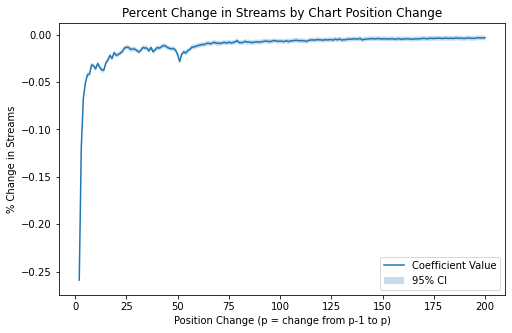

In [5]:
# extract coefficients from results
beta_vals = results.params
# extract confidence interval values from results
ci_025_vals = results.conf_int(alpha=0.05)[0]
ci_975_vals = results.conf_int(alpha=0.05)[1]
# values of p to iterate through
p_vals = sorted(df['position_p'].unique())

plt.figure(figsize=(8,5))
plt.plot(p_vals, beta_vals, label='Coefficient Value')
plt.fill_between(p_vals, ci_025_vals, ci_975_vals, alpha=0.25, label='95% CI')
plt.title('Percent Change in Streams by Chart Position Change')
plt.xlabel('Position Change (p = change from p-1 to p)')
plt.ylabel('% Change in Streams')
plt.legend()
plt.show()

Zooming in on p = 51:

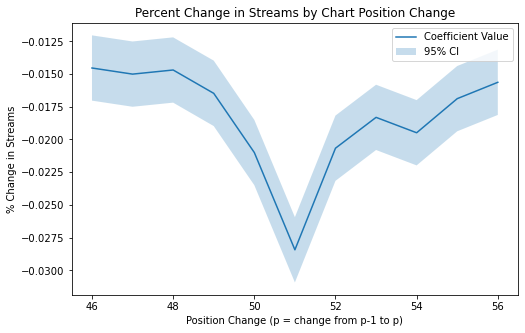

In [6]:
plt.figure(figsize=(8,5))
plt.plot(p_vals[44:55], beta_vals[44:55], label='Coefficient Value')
plt.fill_between(p_vals[44:55], ci_025_vals[44:55], ci_975_vals[44:55], alpha=0.25, label='95% CI')
plt.title('Percent Change in Streams by Chart Position Change')
plt.xlabel('Position Change (p = change from p-1 to p)')
plt.ylabel('% Change in Streams')
plt.legend()
plt.show()

(c)

Regression of log of quotient of lagged streams (the beta values from above) on $p$ with an $I_{p=51}$ indicator variable (regression discontinuity):

In [8]:
# add indicator variable
df['I_p51'] = (df['position_p'] == 51).astype(int)
# new regression with data not split into subsets via p
X = df[['position_p', 'I_p51']]
X = sm.add_constant(X)
y = df['log_q_p_p1'].values
lr = sm.OLS(y, X)
results = lr.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.127
Model:                            OLS   Adj. R-squared:                  0.127
Method:                 Least Squares   F-statistic:                     3071.
Date:                Sat, 20 Nov 2021   Prob (F-statistic):               0.00
Time:                        18:16:49   Log-Likelihood:                 93512.
No. Observations:               42170   AIC:                        -1.870e+05
Df Residuals:                   42167   BIC:                        -1.870e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0297      0.000   -113.968      0.0

(d)

In [9]:
# get estimate of indicator variable coefficient from above
i_est = results.params.loc['I_p51']
# compute total streams at position 50
pos_50_total = df_orig[df_orig['Position'] == 50]['Streams'].sum()
# final value
print(f'{(i_est * pos_50_total):.0f}')

-2022081


(e)

In [10]:
# base of file names
file_base = 'spotifycharts_20170629to20180126_'
# markets from which to read data
markets = ['us', 'au', 'mx']
# dictionary to store table for each market
tables = {}
# dictionaries to store model fit for each market
beta_fits = {}
i_fits = {}
# for each market...
for market in markets:
    
    # table to store values and confidence intervals
    table = pd.DataFrame(columns=['Parameter', 'Estimate', '[0.025', '0.975]'])
    
    # read data
    df = pd.read_csv(file_dir+file_base+market+'.csv')
    
    # apply data wrangling
    
    # only need date, streams, and position for this analysis
    df = df[['date', 'Position', 'Streams']].rename(columns={'Position': 'position_p1', 'Streams': 'streams_p1'})
    # add new column with streams and position of the next track
    df['position_p'] =  df['position_p1'] + 1
    df['streams_p'] = (df['streams_p1'].shift(-1))
    # only want to make comparisons from the same dates
    df = df[df['position_p'] != 201].reset_index(drop=True)
    # convert to int
    df['streams_p'] = df['streams_p'].astype(int)
    # divide streams at position p by streams at position p-1
    df['quotient_p_p1'] = df['streams_p'] / df['streams_p1']
    # calculate lift from quotient
    df['log_q_p_p1'] = np.log(df['quotient_p_p1'])

    # implement regression to get beta values
    df_sub = df[['position_p', 'log_q_p_p1']]
    df_sub = pd.get_dummies(df_sub, columns=['position_p'])
    X = df_sub.drop(columns=['log_q_p_p1'])
    y = df_sub['log_q_p_p1']
    lr = sm.OLS(y, X)
    results = lr.fit()
    # extract coefficients from results
    beta_vals = results.params
    beta_store = list(beta_vals[38:59]) # want to store coefficeints for p = 40-60 and indexing starts at 2
    # extract confidence interval values from results
    ci_025_vals = results.conf_int(alpha=0.05)[0]
    ci_025_store = list(ci_025_vals[38:59]) # store coefficeints for p = 40-60
    ci_975_vals = results.conf_int(alpha=0.05)[1]
    ci_975_store = list(ci_975_vals[38:59]) # store coefficeints for p = 40-60
    # store model fit
    beta_fits[market] = results.rsquared

    # compute estimate of indicator variable (i.e., estimate of effect of placement in top 50)
    
    # add indicator variable
    df['I_p51'] = (df['position_p'] == 51).astype(int)
    # new regression with data not split into subsets via p
    X = df[['position_p', 'I_p51']]
    X = sm.add_constant(X)
    y = df['log_q_p_p1'].values
    lr = sm.OLS(y, X)
    results = lr.fit()
    # get estimate of indicator variable coefficient from above
    i_est = results.params.loc['I_p51']
    # get 95% CI
    i_025, i_975 = results.conf_int(alpha=0.05).loc['I_p51'][0], results.conf_int(alpha=0.05).loc['I_p51'][1]
    # store model fit
    i_fits[market] = results.rsquared
    
    # form columns
    parameters = ['I_p51'] + [f'beta_{i}' for i in range (40,61)]
    estimates = [i_est] + beta_store
    ci_025s = [i_025] + ci_025_store
    ci_975s = [i_975] + ci_975_store
    
    # insert columns into table
    table['Parameter'] = parameters
    table['Estimate'] = estimates
    table['[0.025'] = ci_025s
    table['0.975]'] = ci_975s
    
    # store table
    tables[market] = table

In [11]:
# unpack tables
us, au, mx = tables['us'], tables['au'], tables['mx']

In [12]:
us.style.set_caption("Parameter Estimates: US")

,Parameter,Estimate,[0.025,0.975]
0,I_p51,-0.001568,-0.006186,0.003049
1,beta_40,-0.014818,-0.018055,-0.011582
2,beta_41,-0.013191,-0.016427,-0.009954
3,beta_42,-0.012662,-0.015898,-0.009425
4,beta_43,-0.013032,-0.016269,-0.009796
5,beta_44,-0.011369,-0.014606,-0.008132
6,beta_45,-0.010909,-0.014145,-0.007672
7,beta_46,-0.012413,-0.015650,-0.009177
8,beta_47,-0.013938,-0.017174,-0.010701
9,beta_48,-0.016571,-0.019807,-0.013334


In [13]:
au.style.set_caption("Parameter Estimates: AU")

,Parameter,Estimate,[0.025,0.975]
0,I_p51,-0.040016,-0.042894,-0.037138
1,beta_40,-0.014132,-0.016501,-0.011762
2,beta_41,-0.017994,-0.020364,-0.015625
3,beta_42,-0.015187,-0.017556,-0.012818
4,beta_43,-0.017119,-0.019489,-0.014750
5,beta_44,-0.016122,-0.018497,-0.013747
6,beta_45,-0.017365,-0.019734,-0.014996
7,beta_46,-0.018578,-0.020948,-0.016209
8,beta_47,-0.019673,-0.022048,-0.017299
9,beta_48,-0.022927,-0.025297,-0.020558


In [14]:
mx.style.set_caption("Parameter Estimates: MX")

,Parameter,Estimate,[0.025,0.975]
0,I_p51,-0.007033,-0.009562,-0.004505
1,beta_40,-0.012609,-0.014770,-0.010448
2,beta_41,-0.013816,-0.015972,-0.011660
3,beta_42,-0.013186,-0.015342,-0.011030
4,beta_43,-0.013590,-0.015746,-0.011434
5,beta_44,-0.015327,-0.017483,-0.013171
6,beta_45,-0.015455,-0.017611,-0.013299
7,beta_46,-0.015499,-0.017655,-0.013343
8,beta_47,-0.016105,-0.018261,-0.013949
9,beta_48,-0.016021,-0.018177,-0.013865


Create a table of model fits:

In [15]:
# initialize tables
fits = pd.DataFrame(columns=['Region', 'Beta Model R2', 'I_p51 Model R2'])
# zip fit dictionaries in a dict with tuples as the values and countries as keys
fits_dicts = [beta_fits, i_fits]
zipped = {}
for k in beta_fits.keys():
    zipped[k] = tuple(zipped[k] for zipped in fits_dicts)
    
# index for appending rows to dataframe
i = 0
# insert info into dataframe
for region,r2s in zipped.items():
    fits.loc[i] = [region, r2s[0], r2s[1]]
    i += 1
    
fits.style.set_caption('Model Fits')

,Region,Beta Model R2,I_p51 Model R2
0,us,0.547094,0.082043
1,au,0.438613,0.175049
2,mx,0.436982,0.228852


Verifying table creation:

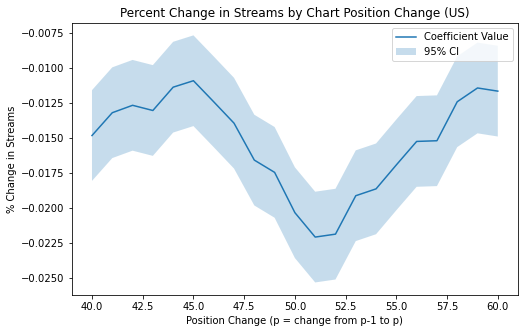

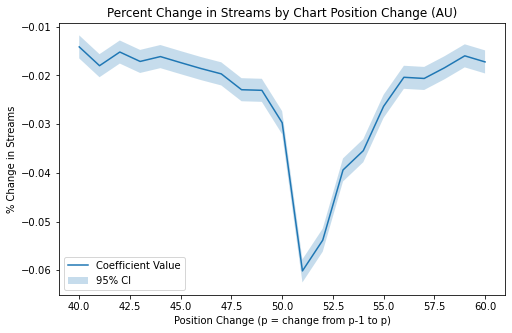

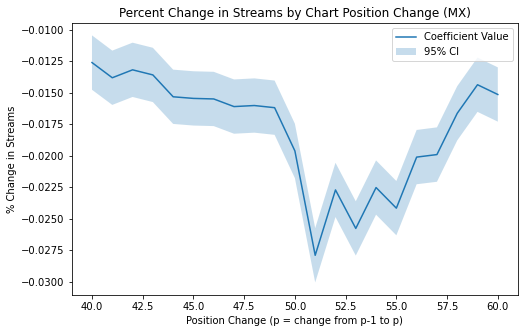

In [16]:
# values of p for axis labels
p_vals = [i for i in range(40,61)]

for country,table in tables.items():
    
    beta_ests = table[1:]['Estimate'].values
    ci_low = table[1:]['[0.025']
    ci_high = table[1:]['0.975]']
    
    plt.figure(figsize=(8,5))
    plt.plot(p_vals, beta_ests, label='Coefficient Value')
    plt.fill_between(p_vals, ci_low, ci_high, alpha=0.25, label='95% CI')
    plt.title(f'Percent Change in Streams by Chart Position Change ({country.upper()})')
    plt.xlabel('Position Change (p = change from p-1 to p)')
    plt.ylabel('% Change in Streams')
    plt.legend()
    plt.show()